# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.autograd import Variable
import torch
import torchvision

## Carregamento dos dados do MNIST

In [52]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [53]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [54]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

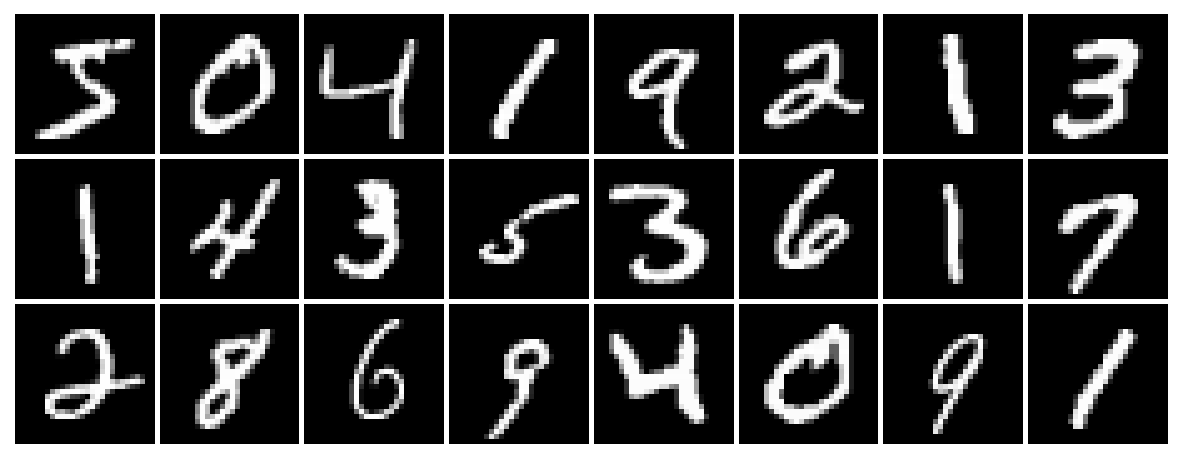

In [55]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


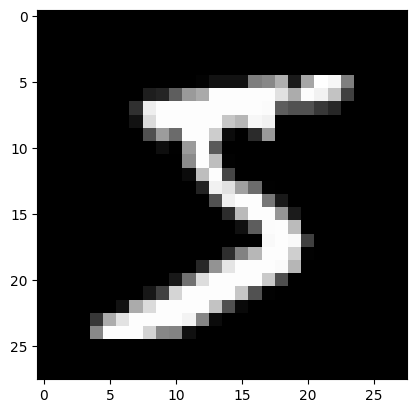

In [56]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy().reshape(28,28), cmap='gray')
print('class:', target)

## Modelo

In [57]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [58]:
## TODO
import torch.nn.functional as F
x_pred = x_train[0:4].view(-1, 28*28)
x_pred.size()

y_pred = model(x_pred)
#softmax
y_prob = F.softmax(y_pred, dim=1)*100
print(y_prob)

tensor([[10.1632,  8.1232, 11.7978, 10.5932, 11.5311, 14.9238,  7.0733, 10.8594,
          6.0785,  8.8565],
        [11.5769, 11.1084, 11.1371, 10.4006, 10.3735, 14.0561,  7.1060,  8.1433,
          7.0729,  9.0252],
        [11.5730, 11.2828,  8.8609,  9.4062, 10.6328,  8.5935,  6.5290, 12.2051,
          9.2125, 11.7042],
        [12.3572,  7.1471, 12.4165, 11.2552,  7.6286,  8.8239,  9.4503, 10.9851,
          8.6330, 11.3029]], grad_fn=<MulBackward0>)


## Treinamento

### Inicialização dos parâmetros

In [59]:
epochs = 5
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [60]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-aijd5w4q
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-aijd5w4q
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


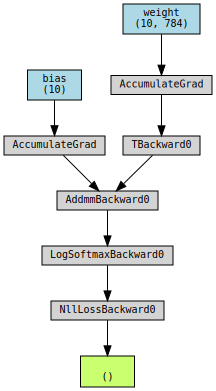

In [61]:
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
from torchviz import make_dot, make_dot_from_trace
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [62]:
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()

except KeyboardInterrupt:
    pass

<Figure size 1800x600 with 0 Axes>

In [63]:
model.weight.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [64]:
print('Final loss:', loss.data)

Final loss: tensor(1.1064)


### Visualizando gráfico de perda durante o treinamento

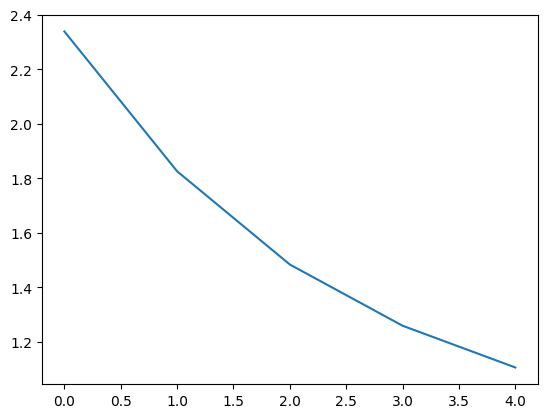

In [65]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [66]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.819


### Matriz de confusão com dados de treinamento e teste

In [67]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,93,0,4,1,0,7,2,2,0,3
1,0,110,14,1,1,2,3,7,8,2
2,1,0,64,0,1,2,0,1,2,0
3,0,0,1,81,0,15,0,0,9,1
4,0,0,2,0,90,4,1,4,0,4
5,0,2,0,1,0,51,1,0,2,2
6,2,1,5,1,4,3,87,0,0,1
7,0,0,5,4,1,1,0,98,0,6
8,1,2,3,2,0,5,0,0,64,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


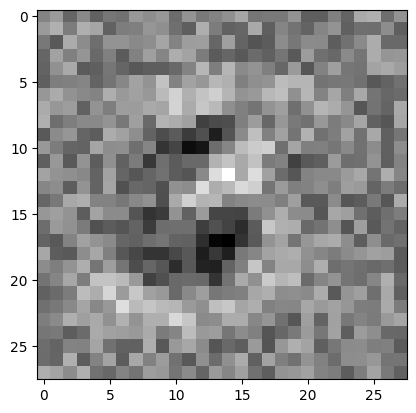

In [68]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

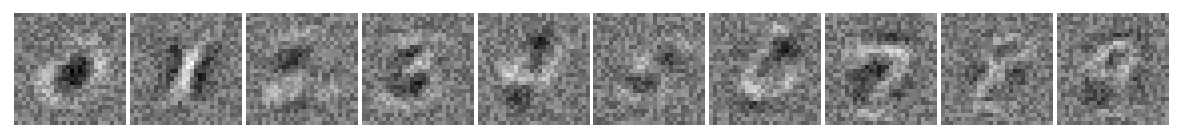

In [69]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [70]:
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print(f'Época: {i+1}/{epochs}, Accuracy: {accuracy}, Loss: {loss.data.detach().numpy():.6f}')

except KeyboardInterrupt:
    pass

Época: 1/5, Accuracy: 0.819, Loss: 0.996631
Época: 2/5, Accuracy: 0.833, Loss: 0.914327
Época: 3/5, Accuracy: 0.839, Loss: 0.850710
Época: 4/5, Accuracy: 0.848, Loss: 0.799824
Época: 5/5, Accuracy: 0.852, Loss: 0.758047


<Figure size 1800x600 with 0 Axes>

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

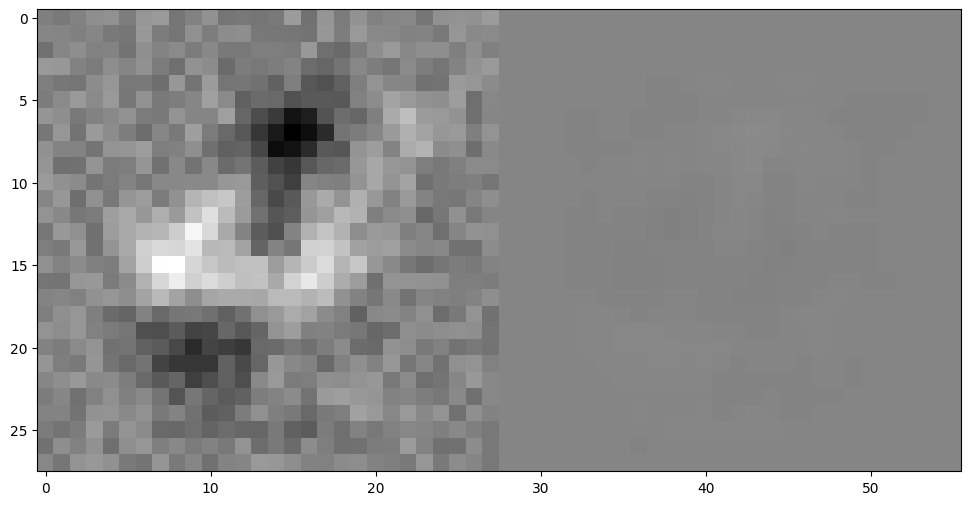

In [79]:
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

pesos_epocas = []
gradientes_epocas = []

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)

        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        # input(i)

        weights_d_ = model.weight.data[4].cpu().clone().numpy().reshape(28, 28)
        weights_g_ = model.weight.grad[4].cpu().clone().numpy().reshape(28, 28)

        pesos_epocas.append(weights_d_)
        gradientes_epocas.append(weights_g_)

        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        # print(f'Época: {i+1}/{epochs}, Accuracy: {accuracy}, Loss: {loss.data.detach().numpy():.6f}')

except KeyboardInterrupt:
    pass

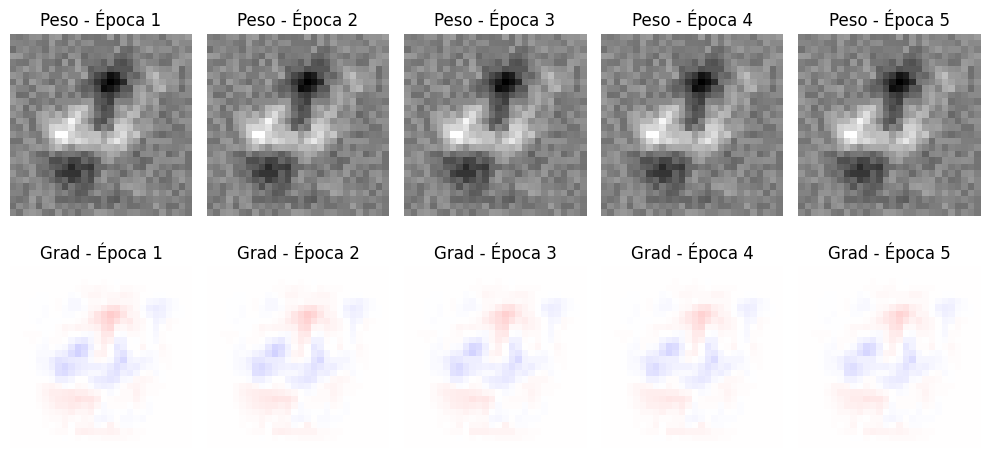

In [80]:
n_epochs = len(pesos_epocas)
fig, axs = plt.subplots(2, n_epochs, figsize=(2*n_epochs, 5))

for i in range(n_epochs):
    axs[0, i].imshow(pesos_epocas[i], cmap='gray')
    axs[0, i].set_title(f'Peso - Época {i+1}')
    axs[1, i].imshow(gradientes_epocas[i], cmap='bwr', vmin=-0.05, vmax=0.05)
    axs[1, i].set_title(f'Grad - Época {i+1}')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

In [81]:
# Comparar pesos entre época 1 e 2
diff = np.abs(pesos_epocas[1] - pesos_epocas[0])
print("Variação média dos pesos da classe 4 entre época 1 e 2:", np.mean(diff))

# Comparar gradientes entre época 1 e 2
diff_g = np.abs(gradientes_epocas[1] - gradientes_epocas[0])
print("Variação média dos gradientes da classe 4 entre época 1 e 2:", np.mean(diff_g))

Variação média dos pesos da classe 4 entre época 1 e 2: 0.0005003654
Variação média dos gradientes da classe 4 entre época 1 e 2: 4.4538683e-05


<details>
<summary>Mostrar Resultado</summary>

```python
from IPython import display
import numpy
a = 5
losses = []
zs = []
fig = plt.figure(figsize=(18, 6))

try:
    for i in range(epochs):
        # Transforma a entrada para uma dimensão
        inputs = Variable(x_train.view(-1, 28 * 28))
        # Predict da rede
        outputs = model(inputs)
        zs.append(outputs[1].detach().numpy())

        # calcula a perda
        loss = criterion(outputs, Variable(y_train))

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data)
        weights_d = model.weight.data[4].numpy().reshape(28,28)
        weights_g = model.weight.grad.data[4].numpy().reshape(28,28)
        ww = np.concatenate((weights_d,weights_g),1)
        plt.imshow(ww.reshape((28,28*2)),cmap = 'gray')
        display.display(fig)
        display.clear_output(wait=True)
        input(i)
        
        _, predicts = torch.max(outputs, 1)

        y_pred = predicts.data
        accuracy = (y_pred.numpy() == y_train.numpy()).mean()
        print('Accuracy:', accuracy)
        print("epoca: " + str(i + 1))
        print("perda: " + str(loss.data.detach().numpy()))
except KeyboardInterrupt:
    pass
```

</details>



## Perguntas

1. Qual é o shape da matriz de entrada na rede?
<br>`torch.Size([1000, 28, 28])` -> Matriz [1000,784]

2. Qual é o shape da saída da rede?
<br>[1000,10] 1000 amostras de imagens com 10 classes

3. Qual é o número total de parâmetros da rede, incluindo o bias?
<br>7850, sendo os pesos (10,784) que corresponde a 7840 pesos mais 1 bias para cada parâmetro, totalizando 7850 parâmetros

# Aprendizados


Nesta atividade, foi possível aprender como uma rede neural pode ser treinada para reconhecer dígitos manuscritos, ajustando seus parâmetros com base nos erros cometidos. Visualizamos os pesos e gradientes da rede, entendendo como ela aprende a identificar padrões nas imagens. Foi possível ver, na prática, como os dados passam pela rede, como os erros são calculados e como os parâmetros se atualizam a cada época para melhorar o desempenho. Além disso, foi verificado graficamente a evolução do ajuste dos pesos para cada época.